In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Qiskit Imports
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, ADAM, SPSA
from qiskit_machine_learning.neural_networks import SamplerQNN

# IBM Cloud Imports (To musisz doinstalować: pip install qiskit-ibm-runtime)
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options

# --- IMPORTY DLA IBM ---
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit import transpile  # <--- WAŻNY NOWY IMPORT

In [2]:
TRAIN_PATIENTS = ['100', '101', '102']
TEST_PATIENTS = ['106', '119']

SAMPLES_BEFORE = 30
SAMPLES_AFTER = 60
WINDOW_SIZE = SAMPLES_BEFORE + SAMPLES_AFTER

# Cechy PCA - tyle kubitów
N_DIM = 8
LIMIT_PER_PATIENT = 600

NORMAL_SYMBOLS = ['N', 'L', 'R', 'e', 'j']
ANOMALY_SYMBOLS = ['V', 'A', 'a', 'J', 'S', 'F', '!', 'E', '/']

In [3]:
def load_patient_data(patiend_id):
    # Wczytuje sygnał i wycina uderzenia na podstawie adnotacji
    ekg_file = f'archive/{patiend_id}_ekg.csv'
    ann_file = f'archive/{patiend_id}_annotations_1.csv'
    
    if not os.path.exists(ekg_file) or not os.path.exists(ann_file):
        print('nie ma pliku')
        return [], []
    
    # wczytywanie sygnału ekg dla pacjenta, szukam po tej kolumnie MLII
    df_ekg = pd.read_csv(ekg_file)
    # Usuwamy spacje z nazw kolumn (częsty błąd w CSV)
    df_ekg.columns = df_ekg.columns.str.strip()
    
    try:
        if 'MLII' in df_ekg.columns:
                signal = df_ekg['MLII'].values
        elif 'V5' in df_ekg.columns:
            signal = df_ekg['V5'].values
        else:
            # Jeśli nie ma nazw, bierzemy kolumnę indeks 1 (bo 0 to zazwyczaj czas/sample)
            signal = df_ekg.iloc[:, 1].values
    except Exception as e:
        print(f'error {e}')
        return [], []
    
    signal = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))
    
    try:
        df_ann = pd.read_csv(ann_file)
        df_ann.columns = df_ann.columns.str.strip() # Czyścimy nazwy
            
        # Szukamy odpowiednich kolumn (sample = pozycja, symbol = typ)
        # Czasami nazywają się 'sample', 'Sample', 'time', etc.
        sample_col = next((c for c in df_ann.columns if 'index' in c.lower()), None)
        symbol_col = next((c for c in df_ann.columns if 'annotation_symbol' in c.lower()), None)
        
        if not sample_col or not symbol_col:
            print("  Nie znaleziono kolumn 'sample' lub 'symbol' w adnotacjach.")
            return [], []
        
        peaks = df_ann[sample_col].values
        symbols = df_ann[symbol_col].values
    except Exception as e:
        print(f'blad {e}')
        return [], []
    
    beats_normal = []
    beats_anomaly = []
    
    for p, sym in zip(peaks, symbols):
        # Pomijamy uderzenia na samym początku lub końcu nagrania
        if p - SAMPLES_BEFORE < 0 or p + SAMPLES_AFTER > len(signal):
            continue
            
        # Wycinek
        window = signal[p - SAMPLES_BEFORE : p + SAMPLES_AFTER]
        
        # Upewniamy się, że długość jest idealna
        if len(window) != WINDOW_SIZE:
            continue

        # Klasyfikacja
        if sym in NORMAL_SYMBOLS:
            if len(beats_normal) < LIMIT_PER_PATIENT:
                beats_normal.append(window)
        elif sym in ANOMALY_SYMBOLS:
            if len(beats_anomaly) < LIMIT_PER_PATIENT:
                beats_anomaly.append(window)
                
    print(f"  -> Znaleziono: {len(beats_normal)} Normal, {len(beats_anomaly)} Anomaly")
    return beats_normal, beats_anomaly

>>> KROK 1: Wczytywanie danych treningowych (Zdrowi)...
  -> Znaleziono: 600 Normal, 34 Anomaly
  -> Znaleziono: 600 Normal, 3 Anomaly
  -> Znaleziono: 99 Normal, 600 Anomaly

>>> KROK 2: Wczytywanie danych testowych (Mieszane)...
  -> Znaleziono: 600 Normal, 520 Anomaly
  -> Znaleziono: 600 Normal, 444 Anomaly

STATUS DANYCH SUROWYCH:
Wymiar pojedynczego uderzenia: 90 próbek
Liczba próbek Train (Normal): 1299
Liczba próbek Test (Anomaly): 964

>>> KROK 3: Redukcja wymiaru (PCA) z 90 do 8...
Wyjaśniona wariancja (ile info zachowaliśmy): 99.48%
>>> KROK 4: Skalowanie do zakresu (0, pi)...

>>> KROK 5: Zapisywanie plików .npy...
GOTOWE! Możesz teraz uruchomić skrypt z Qiskit.

>>> Generowanie wykresu kontrolnego...


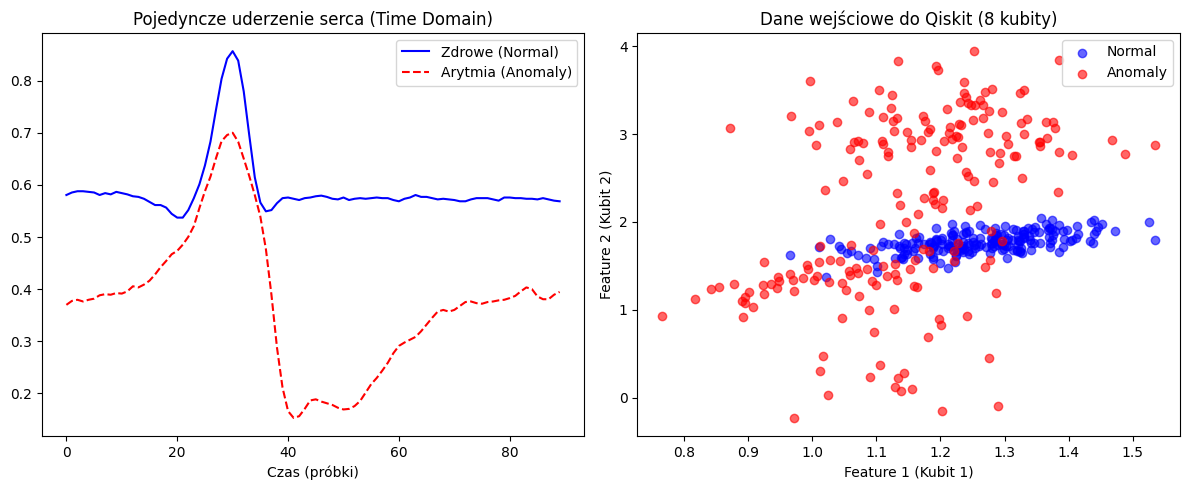

In [4]:
def main():
    # --- ZBIERANIE DANYCH ---
    all_train_normal = []
    all_test_normal = []
    all_test_anomaly = []

    print(">>> KROK 1: Wczytywanie danych treningowych (Zdrowi)...")
    for pid in TRAIN_PATIENTS:
        n, _ = load_patient_data(pid)
        all_train_normal.extend(n)

    print("\n>>> KROK 2: Wczytywanie danych testowych (Mieszane)...")
    for pid in TEST_PATIENTS:
        n, a = load_patient_data(pid)
        all_test_normal.extend(n)
        all_test_anomaly.extend(a)

    # Konwersja na numpy array
    X_train = np.array(all_train_normal)
    X_test_normal = np.array(all_test_normal)
    X_test_anomaly = np.array(all_test_anomaly)

    print(f"\nSTATUS DANYCH SUROWYCH:")
    print(f"Wymiar pojedynczego uderzenia: {WINDOW_SIZE} próbek")
    print(f"Liczba próbek Train (Normal): {X_train.shape[0]}")
    print(f"Liczba próbek Test (Anomaly): {X_test_anomaly.shape[0]}")

    if len(X_train) == 0:
        print("BŁĄD KRYTYCZNY: Brak danych treningowych. Sprawdź nazwy plików CSV!")
        return

    # --- PRZETWARZANIE (PCA) ---
    print(f"\n>>> KROK 3: Redukcja wymiaru (PCA) z {WINDOW_SIZE} do {N_DIM}...")
    
    # 1. Trenujemy PCA tylko na zdrowych danych treningowych
    pca = PCA(n_components=N_DIM)
    pca.fit(X_train)
    
    # 2. Transformujemy wszystkie zbiory
    X_train_pca = pca.transform(X_train)
    X_test_normal_pca = pca.transform(X_test_normal)
    
    # Obsługa przypadku, gdyby nie było anomalii (żeby kod nie padł)
    if len(X_test_anomaly) > 0:
        X_test_anomaly_pca = pca.transform(X_test_anomaly)
    else:
        X_test_anomaly_pca = np.empty((0, N_DIM))

    print(f"Wyjaśniona wariancja (ile info zachowaliśmy): {sum(pca.explained_variance_ratio_):.2%}")

    # --- SKALOWANIE DO KOMPUTERA KWANTOWEGO ---
    # Qiskit lubi dane w zakresie (0, pi) lub (-1, 1). 
    # Użyjemy (0, pi) pod bramki rotacji.
    print(">>> KROK 4: Skalowanie do zakresu (0, pi)...")
    
    scaler = MinMaxScaler(feature_range=(0, np.pi))
    scaler.fit(X_train_pca) # Uczymy skaler na treningu
    
    X_train_final = scaler.transform(X_train_pca)
    X_test_normal_final = scaler.transform(X_test_normal_pca)
    
    if len(X_test_anomaly) > 0:
        X_test_anomaly_final = scaler.transform(X_test_anomaly_pca)
    else:
        X_test_anomaly_final = X_test_anomaly_pca

    # --- ZAPISYWANIE ---
    print("\n>>> KROK 5: Zapisywanie plików .npy...")
    np.save('train_data.npy', X_train_final)
    np.save('test_normal.npy', X_test_normal_final)
    np.save('test_anomaly.npy', X_test_anomaly_final)
    print("GOTOWE! Możesz teraz uruchomić skrypt z Qiskit.")

    # --- WIZUALIZACJA ---
    print("\n>>> Generowanie wykresu kontrolnego...")
    plt.figure(figsize=(12, 5))
    
    # Wykres 1: Jak wygląda surowe uderzenie?
    plt.subplot(1, 2, 1)
    plt.plot(X_train[0], label='Zdrowe (Normal)', color='blue')
    if len(X_test_anomaly) > 0:
        plt.plot(X_test_anomaly[0], label='Arytmia (Anomaly)', color='red', linestyle='--')
    plt.title("Pojedyncze uderzenie serca (Time Domain)")
    plt.xlabel("Czas (próbki)")
    plt.legend()
    
    # Wykres 2: Jak to wygląda po PCA?
    plt.subplot(1, 2, 2)
    # Rysujemy tylko po 100 kropek żeby było czytelnie
    plt.scatter(X_test_normal_final[:200, 0], X_test_normal_final[:200, 1], 
                c='blue', alpha=0.6, label='Normal')
    if len(X_test_anomaly_final) > 0:
        plt.scatter(X_test_anomaly_final[:200, 0], X_test_anomaly_final[:200, 1], 
                    c='red', alpha=0.6, label='Anomaly')
    plt.title(f"Dane wejściowe do Qiskit ({N_DIM} kubity)")
    plt.xlabel("Feature 1 (Kubit 1)")
    plt.ylabel("Feature 2 (Kubit 2)")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

C:\Users\Marcepano\AppData\Local\Temp\ipykernel_16188\3181132310.py:43: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._z_feature_map.ZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the z_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZFeatureMap(feature_dimension=INPUT_DIM, reps=1)
C:\Users\Marcepano\AppData\Local\Temp\ipykernel_16188\3181132310.py:45: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz = RealAmplitudes(num_qubits=INPUT_DIM, reps=2, entanglement='linear')
No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


>>> 1. Wczytywanie danych (8 cech)...
    Trening na: 1299 próbkach
>>> 2. Budowanie obwodu (8 kubitów)...
>>> 3. Start treningu (Optimizer: SPSA, Iter: 60)...
    Iter 5: Koszt = 0.4987
    Iter 10: Koszt = 0.4943
    Iter 15: Koszt = 0.5283
    Iter 20: Koszt = 0.4519
    Iter 25: Koszt = 0.5882
    Iter 30: Koszt = 0.5046
    Iter 35: Koszt = 0.4552
    Iter 40: Koszt = 0.5484
    Iter 45: Koszt = 0.4529
    Iter 50: Koszt = 0.5138
    Iter 55: Koszt = 0.5007
    Iter 60: Koszt = 0.2545
    Iter 65: Koszt = 0.2218
    Iter 70: Koszt = 0.2350
    Iter 75: Koszt = 0.2249
    Iter 80: Koszt = 0.2936
    Iter 85: Koszt = 0.2085
    Iter 90: Koszt = 0.1561
    Iter 95: Koszt = 0.1572
    Iter 100: Koszt = 0.1759
    Iter 105: Koszt = 0.1796
    Iter 110: Koszt = 0.1915
    Iter 115: Koszt = 0.1880
    Iter 120: Koszt = 0.1992
    Iter 125: Koszt = 0.1858
    Iter 130: Koszt = 0.1634
    Iter 135: Koszt = 0.1273
    Iter 140: Koszt = 0.1571
    Iter 145: Koszt = 0.1152
    Iter 150: Koszt

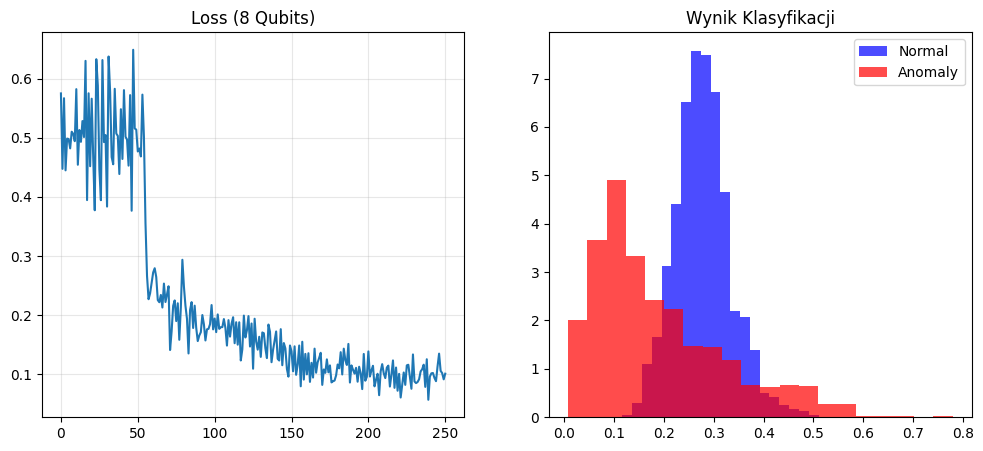

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Qiskit Imports
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, ADAM, SPSA
from qiskit_machine_learning.neural_networks import SamplerQNN

# IBM Cloud Imports (To musisz doinstalować: pip install qiskit-ibm-runtime)
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options

# --- KONFIGURACJA ---
USE_REAL_HARDWARE = False  # <--- Zmień na True, jak będziesz gotowy na IBM
IBM_TOKEN = "TU_WKLEJ_SWOJ_TOKEN_Z_IBM_QUANTUM" 

INPUT_DIM = 8     # Teraz mamy 8 cech
LATENT_DIM = 4    # Kompresujemy do 4 kubitów
MAX_ITER = 60     # Dajmy mu trochę czasu
BATCH_SIZE = 25 


print(f">>> 1. Wczytywanie danych (8 cech)...")
try:
    train_data = np.load('train_data.npy')
    test_normal = np.load('test_normal.npy')
    test_anomaly = np.load('test_anomaly.npy')
except:
    print("BŁĄD: Nie znaleziono plików. Uruchom najpierw prepare_data.py z N_DIM=8!")
    raise ValueError

# Sprawdzenie czy wymiary pasują
if train_data.shape[1] != INPUT_DIM:
    print(f"BŁĄD: Dane mają wymiar {train_data.shape[1]}, a kod oczekuje {INPUT_DIM}.")
    raise ValueError

print(f"    Trening na: {len(train_data)} próbkach")

# --- OBWÓD KWANTOWY ---
print(">>> 2. Budowanie obwodu (8 kubitów)...")
# ZFeatureMap jest OK, ale ZZFeatureMap bywa lepsza (choć wolniejsza). Zostańmy przy Z.
feature_map = ZFeatureMap(feature_dimension=INPUT_DIM, reps=1)
# reps=2 da lepszą ekspresję niż reps=1
ansatz = RealAmplitudes(num_qubits=INPUT_DIM, reps=2, entanglement='linear')

qc = QuantumCircuit(INPUT_DIM)
qc.append(feature_map, range(INPUT_DIM))
qc.append(ansatz, range(INPUT_DIM))

# --- WYBÓR BACKENDU (Symulator vs Prawdziwy) ---
if USE_REAL_HARDWARE:
    print(">>> ŁĄCZENIE Z IBM QUANTUM...")
    # Zapisz konto (robisz to tylko raz)
    # QiskitRuntimeService.save_account(channel="ibm_quantum", token=IBM_TOKEN, overwrite=True)
    service = QiskitRuntimeService(channel="ibm_quantum")
    
    # Wybór najmniej obciążonego komputera
    backend = service.least_busy(operational=True, simulator=False)
    print(f"    Wybrano komputer: {backend.name}")
    # Tutaj konfiguracja Samplera dla IBM jest trudniejsza w pętli treningowej.
    # UWAGA: Trenowanie na prawdziwym sprzęcie zje Ci cały limit w 5 minut.
    # ZALECENIE: Trenuj na symulatorze, a na IBM puść tylko WALIDACJĘ (ostatni krok).
    print("!!! OSTRZEŻENIE: Trening na QPU jest bardzo wolny i kosztowny.")
    print("!!! Przełączam na lokalny symulator do treningu.")

# Do treningu ZAWSZE używamy symulatora (chyba że masz budżet szejka naftowego)

def parity(x):
    return x % 2

qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=2
)

# --- TRENING ---
objective_func_vals = []

def cost_func(params_values):
    batch_idx = np.random.choice(len(train_data), BATCH_SIZE, replace=False)
    batch_data = train_data[batch_idx]
    probs = qnn.forward(batch_data, params_values)
    cost = np.sum(probs[:, 1]) / BATCH_SIZE
    objective_func_vals.append(cost)
    if len(objective_func_vals) % 5 == 0:
        print(f"    Iter {len(objective_func_vals)}: Koszt = {cost:.4f}")
    return cost

print(f">>> 3. Start treningu (Optimizer: SPSA, Iter: {MAX_ITER})...")

# --- ZMIANA TUTAJ ---
# COBYLA wyrzucamy:
# optimizer = COBYLA(maxiter=MAX_ITER) 

# Wstawiamy ADAM. 
# lr=0.01 to "learning rate". Jak wykres skacze jak szalony, zmniejsz do 0.001.
#optimizer = ADAM(maxiter=MAX_ITER, lr=0.01) 
optimizer = SPSA(maxiter=100)

initial_weights = 0.1 * (2 * np.random.random(ansatz.num_parameters) - 1)

start_t = time.time()
# ADAM wymaga gradientów, ale Qiskit SamplerQNN policzy je sobie sam (metodą różnic skończonych)
result = optimizer.minimize(fun=cost_func, x0=initial_weights)
print(f">>> Czas treningu: {time.time() - start_t:.1f} s")

# --- WYNIKI ---
print(">>> 4. Generowanie wyników...")
trained_weights = result.x

# Funkcja do ewaluacji (z batchem)
def get_scores(data):
    scores = []
    for i in range(0, len(data), 50): # Mniejsze paczki dla 8 kubitów
        batch = data[i:i+50]
        p = qnn.forward(batch, trained_weights)
        scores.extend(p[:, 1])
    return scores

s_norm = get_scores(test_normal)
s_anom = get_scores(test_anomaly)

# --- WIZUALIZACJA ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(objective_func_vals)
plt.title("Loss (8 Qubits)")
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(s_norm, bins=20, alpha=0.7, color='blue', label='Normal', density=True)
plt.hist(s_anom, bins=20, alpha=0.7, color='red', label='Anomaly', density=True)
plt.title("Wynik Klasyfikacji")
plt.legend()
plt.savefig("results_8qubits.png")
plt.show()

qiskit_runtime_service._discover_account:WARNING:2026-01-11 21:09:17,385: Loading account with the given token. A saved account will not be used.



>>> 🚀 ROZPOCZYNAMY WALIDACJĘ NA IBM (TRYB JOB/V2)...


qiskit_runtime_service.__init__:WARNING:2026-01-11 21:09:25,043: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2026-01-11 21:09:25,606: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2026-01-11 21:09:28,364: Using instance: open-instance, plan: open


    Wybrano komputer: ibm_fez
    Oczekujących zadań: 0
    Wysyłam 40 próbek jako JEDEN JOB...
>>> Transpilacja obwodu do układu bramek sprzętu (ISA)...


No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


>>> Czekanie na wynik z IBM Quantum (to chwilę potrwa)...
>>> JOB UKOŃCZONY! Wyniki pobrane.


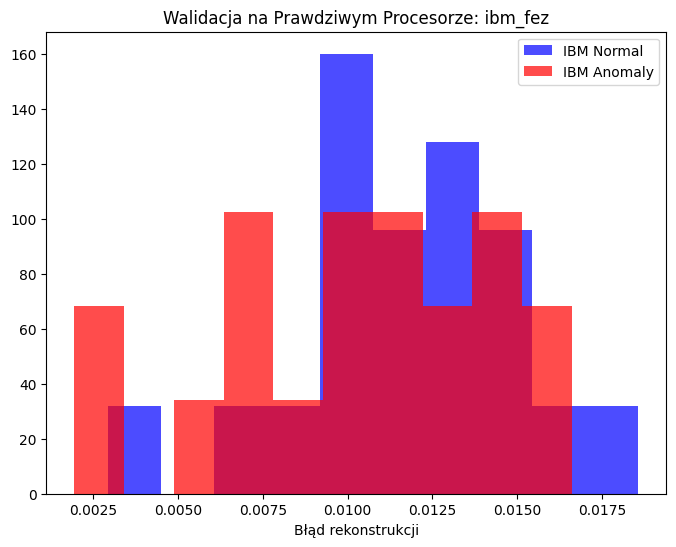

In [6]:
# TWÓJ TOKEN
QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token="ZGyUQq9SXiBMtV5mATQUKl2WfPJPSUIcj5T3pIpN2H0A",
    overwrite=True,
    set_as_default=True
)
MY_TOKEN = "ZGyUQq9SXiBMtV5mATQUKl2WfPJPSUIcj5T3pIpN2H0A" 

print("\n>>> 🚀 ROZPOCZYNAMY WALIDACJĘ NA IBM (TRYB JOB/V2)...")

# 1. Łączenie
service = QiskitRuntimeService(channel="ibm_quantum_platform", token=MY_TOKEN)
backend = service.least_busy(operational=True, simulator=False)
print(f"    Wybrano komputer: {backend.name}")
print(f"    Oczekujących zadań: {backend.status().pending_jobs}")

# 2. Przygotowanie danych (Batching)
# Używamy zmiennych z poprzedniej komórki (upewnij się, że KOMÓRKA 1 była uruchomiona!)
N_TEST = 20
data_normal = test_normal[:N_TEST]
data_anomaly = test_anomaly[:N_TEST]
combined_data = np.concatenate([data_normal, data_anomaly])

print(f"    Wysyłam {len(combined_data)} próbek jako JEDEN JOB...")

# =================================================================
# KROK KLUCZOWY: TRANSPILACJA (Tłumaczenie obwodu na język maszyny)
# =================================================================
print(">>> Transpilacja obwodu do układu bramek sprzętu (ISA)...")
# optimization_level=1 wystarczy, 3 dałoby krótszy obwód, ale trwa dłużej
qc_transpiled = transpile(qc, backend=backend, optimization_level=1)

# 3. Sampler V2
sampler_ibm = Sampler(mode=backend)
sampler_ibm.options.default_shots = 1024

# 4. Podpięcie QNN pod chmurę
# UWAGA: Tutaj podajemy 'circuit=qc_transpiled' zamiast zwykłego 'qc'
qnn_ibm = SamplerQNN(
    circuit=qc_transpiled,          # <--- TUTAJ ZMIANA
    input_params=feature_map.parameters, # Parametry zostają te same (Qiskit o to dba)
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=2,
    sampler=sampler_ibm 
)

# 5. Wykonanie
print(">>> Czekanie na wynik z IBM Quantum (to chwilę potrwa)...")
try:
    job_result = qnn_ibm.forward(combined_data, trained_weights)
    all_scores = job_result[:, 1]
    
    print(">>> JOB UKOŃCZONY! Wyniki pobrane.")

    # 6. Rozdzielenie i Wizualizacja
    scores_ibm_norm = all_scores[:N_TEST]
    scores_ibm_anom = all_scores[N_TEST:]

    plt.figure(figsize=(8, 6))
    plt.hist(scores_ibm_norm, bins=10, alpha=0.7, color='blue', label='IBM Normal', density=True)
    plt.hist(scores_ibm_anom, bins=10, alpha=0.7, color='red', label='IBM Anomaly', density=True)
    plt.title(f"Walidacja na Prawdziwym Procesorze: {backend.name}")
    plt.xlabel("Błąd rekonstrukcji")
    plt.legend()
    plt.savefig("ibm_real_results.png")
    plt.show()

except Exception as e:
    print(f"\nWYSTĄPIŁ BŁĄD PODCZAS PRZETWARZANIA: {e}")
    print("Wskazówka: Jeśli błąd dotyczy limitów użycia, spróbuj zmniejszyć N_TEST do 10.")


>>> Generowanie Macierzy Pomyłek...
--- WYNIKI DLA PROGU 0.14 ---
Dokładność (Accuracy): 76.29%
Precyzja (Precision):  99.78% (Ile z wykrytych arytmii to faktycznie arytmie?)
Czułość (Recall):      46.89% (Ile z prawdziwych arytmii udało się wykryć?)


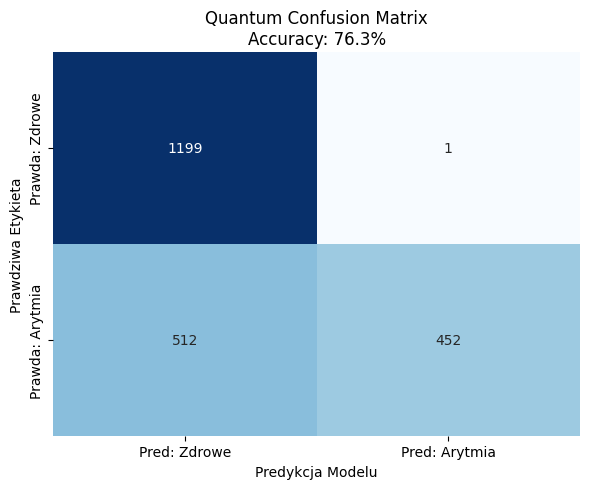

In [9]:
# =============================================
# DODATEK: WIZUALIZACJA MACIERZY POMYŁEK
# =============================================

print("\n>>> Generowanie Macierzy Pomyłek...")

# 1. USTAWIENIE PROGU (THRESHOLD)
# Patrząc na Twój ostatni histogram, idealne przecięcie jest w okolicy 0.14.
# Wszystko poniżej 0.14 traktujemy jako jedną klasę, powyżej jako drugą.
THRESHOLD = 0.14

# 2. PRZYGOTOWANIE ETYKIET PRAWDZIWYCH (Ground Truth)
# 0 = Zdrowe (Normal), 1 = Arytmia (Anomaly)
y_true = [0] * len(s_norm) + [1] * len(s_anom)

# 3. PRZYGOTOWANIE PREDYKCJI MODELU (Z uwzględnieniem INWERSJI!)
# WAŻNE: W Twoim wyniku arytmia (czerwone) ma MAŁY błąd, a zdrowe DUŻY.
# Musimy odwrócić logikę:
# Jeśli wynik < THRESHOLD -> To jest Arytmia (Klasa 1)
# Jeśli wynik > THRESHOLD -> To jest Zdrowe (Klasa 0)

y_pred = []
# Oceniamy zdrowe
for score in s_norm:
    prediction = 1 if score < THRESHOLD else 0
    y_pred.append(prediction)

# Oceniamy chore
for score in s_anom:
    prediction = 1 if score < THRESHOLD else 0
    y_pred.append(prediction)

# 4. OBLICZENIE METRYK
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)

print(f"--- WYNIKI DLA PROGU {THRESHOLD} ---")
print(f"Dokładność (Accuracy): {acc:.2%}")
print(f"Precyzja (Precision):  {prec:.2%} (Ile z wykrytych arytmii to faktycznie arytmie?)")
print(f"Czułość (Recall):      {rec:.2%} (Ile z prawdziwych arytmii udało się wykryć?)")

# 5. RYSOWANIE ŁADNEJ MACIERZY (Seaborn Heatmap)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: Zdrowe', 'Pred: Arytmia'],
            yticklabels=['Prawda: Zdrowe', 'Prawda: Arytmia'])
plt.title(f'Quantum Confusion Matrix\nAccuracy: {acc:.1%}')
plt.ylabel('Prawdziwa Etykieta')
plt.xlabel('Predykcja Modelu')
plt.tight_layout()
plt.savefig("confusion_matrix.png")
# plt.show() # Zakomentowane, bo show() będzie na końcu głównego skryptu


>>> Generowanie Macierzy Pomyłek...
--- WYNIKI DLA PROGU 0.14 ---
Dokładność (Accuracy): 50.00%
Precyzja (Precision):  50.00% (Ile z wykrytych arytmii to faktycznie arytmie?)
Czułość (Recall):      100.00% (Ile z prawdziwych arytmii udało się wykryć?)


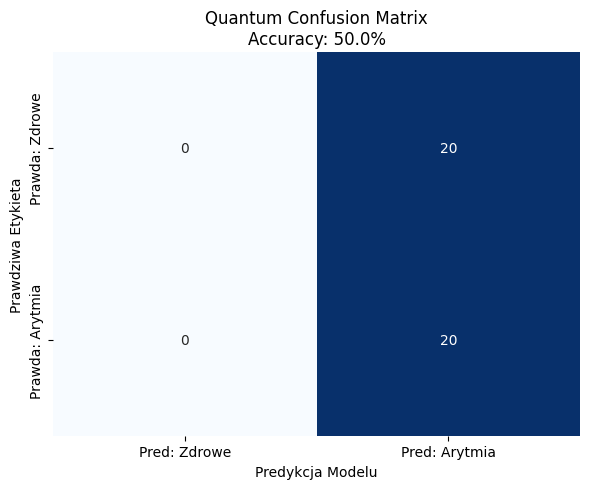

In [10]:
# =============================================
# DODATEK: WIZUALIZACJA MACIERZY POMYŁEK
# =============================================

print("\n>>> Generowanie Macierzy Pomyłek...")

# 1. USTAWIENIE PROGU (THRESHOLD)
# Patrząc na Twój ostatni histogram, idealne przecięcie jest w okolicy 0.14.
# Wszystko poniżej 0.14 traktujemy jako jedną klasę, powyżej jako drugą.
THRESHOLD = 0.14

# 2. PRZYGOTOWANIE ETYKIET PRAWDZIWYCH (Ground Truth)
# 0 = Zdrowe (Normal), 1 = Arytmia (Anomaly)
y_true = [0] * len(scores_ibm_norm) + [1] * len(scores_ibm_anom)

# 3. PRZYGOTOWANIE PREDYKCJI MODELU (Z uwzględnieniem INWERSJI!)
# WAŻNE: W Twoim wyniku arytmia (czerwone) ma MAŁY błąd, a zdrowe DUŻY.
# Musimy odwrócić logikę:
# Jeśli wynik < THRESHOLD -> To jest Arytmia (Klasa 1)
# Jeśli wynik > THRESHOLD -> To jest Zdrowe (Klasa 0)

y_pred = []
# Oceniamy zdrowe
for score in scores_ibm_norm:
    prediction = 1 if score < THRESHOLD else 0
    y_pred.append(prediction)

# Oceniamy chore
for score in scores_ibm_anom:
    prediction = 1 if score < THRESHOLD else 0
    y_pred.append(prediction)

# 4. OBLICZENIE METRYK
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)

print(f"--- WYNIKI DLA PROGU {THRESHOLD} ---")
print(f"Dokładność (Accuracy): {acc:.2%}")
print(f"Precyzja (Precision):  {prec:.2%} (Ile z wykrytych arytmii to faktycznie arytmie?)")
print(f"Czułość (Recall):      {rec:.2%} (Ile z prawdziwych arytmii udało się wykryć?)")

# 5. RYSOWANIE ŁADNEJ MACIERZY (Seaborn Heatmap)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: Zdrowe', 'Pred: Arytmia'],
            yticklabels=['Prawda: Zdrowe', 'Prawda: Arytmia'])
plt.title(f'Quantum Confusion Matrix\nAccuracy: {acc:.1%}')
plt.ylabel('Prawdziwa Etykieta')
plt.xlabel('Predykcja Modelu')
plt.tight_layout()
plt.savefig("confusion_matrix.png")
# plt.show() # Zakomentowane, bo show() będzie na końcu głównego skryptu